In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
import csv
import os

Import dataset

In [2]:
#==== Import Dataset ====
dataset = pd.read_csv('/content/drive/MyDrive/PercobaanTA/Dataset_KUKA_baru_bersih.csv')

pose = dataset.iloc[:, 6:]   # Input labels (last six columns)
jointsAngle = dataset.iloc[:, :6]   # Output features (first six columns)

pose_columns = ['Position x', 'Position y', 'Position z', 'Roll', 'Pitch', 'Yaw']  # Replace with your actual column names
jointsAngle_columns = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4', 'Joint 5', 'Joint 6']  # Replace with your actual column names

#==== Split Dataset ====
split_index = int(0.8 * len(dataset))


jointsAngle_train = jointsAngle[:split_index].values
jointsAngle_test = jointsAngle[split_index:].values
pose_train = pose[:split_index].values
pose_test = pose[split_index:].values


Eksperiment configuration

Streaming output truncated to the last 5000 lines.
39/39 [==============================] - 0s 6ms/step - loss: 0.5455 - val_loss: 79.0639
Epoch 502/3000
39/39 [==============================] - 0s 7ms/step - loss: 0.4557 - val_loss: 73.1300
Epoch 503/3000
39/39 [==============================] - 0s 6ms/step - loss: 0.4662 - val_loss: 79.8061
Epoch 504/3000
39/39 [==============================] - 0s 6ms/step - loss: 0.3559 - val_loss: 86.9752
Epoch 505/3000
39/39 [==============================] - 0s 6ms/step - loss: 0.2279 - val_loss: 83.8758
Epoch 506/3000
39/39 [==============================] - 0s 7ms/step - loss: 0.3619 - val_loss: 94.9737
Epoch 507/3000
39/39 [==============================] - 0s 6ms/step - loss: 0.3369 - val_loss: 84.7684
Epoch 508/3000
39/39 [==============================] - 0s 6ms/step - loss: 0.6390 - val_loss: 94.8059
Epoch 509/3000
39/39 [==============================] - 0s 6ms/step - loss: 0.8936 - val_loss: 93.9352
Epoch 510/3000
39/39 [===============

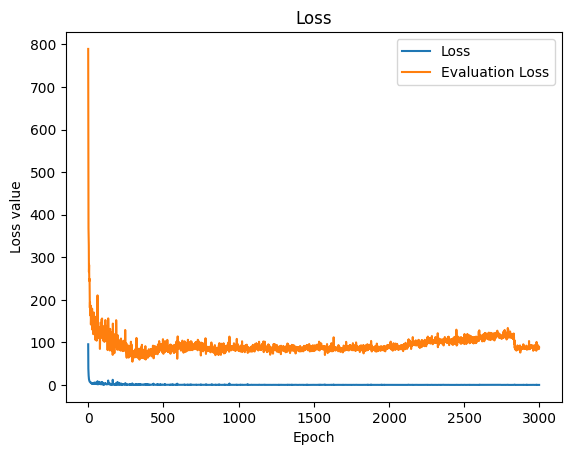

87.63713073730469
0.05734381824731827
10/10 [==============================] - 0s 3ms/step
[[ -51.225796  -108.24865    137.34349     53.91062     43.903107
   -86.71007  ]
 [ -50.424442  -107.48535    136.8219      54.171482    43.23831
   -86.23542  ]
 [ -49.733677  -107.009415   136.38162     54.339466    42.68086
   -85.82915  ]
 ...
 [ -35.406357  -160.51297    191.94563     27.17823     41.180786
   -43.42767  ]
 [ -21.97732   -222.94252    233.7471       3.5623965   81.94107
   -11.803814 ]
 [   3.3549745 -224.11465    201.97299    -12.638358   103.376205
     1.970974 ]]


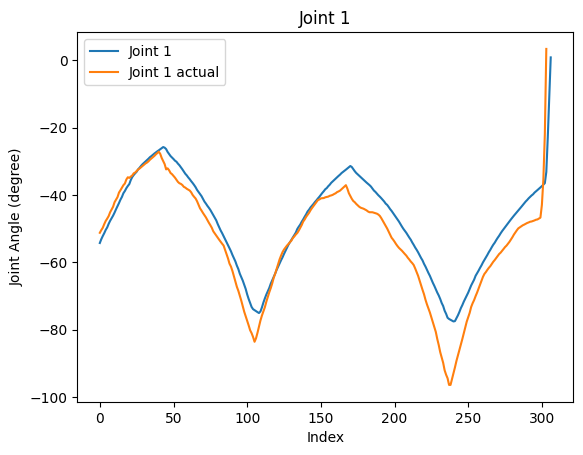

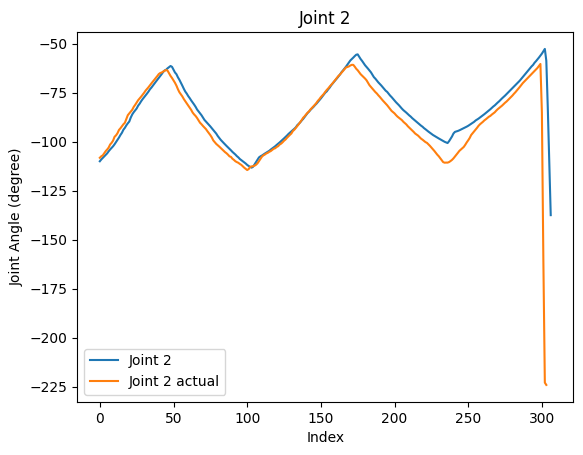

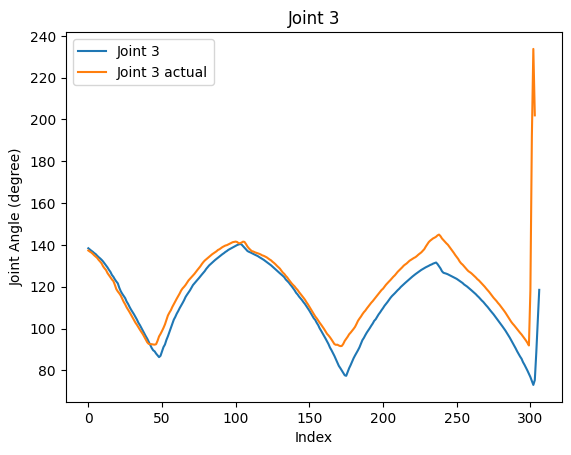

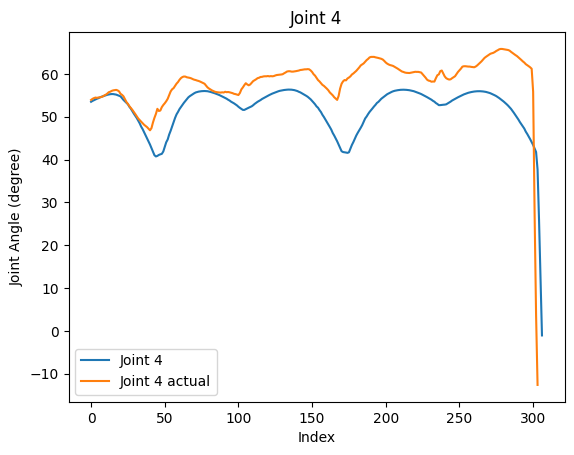

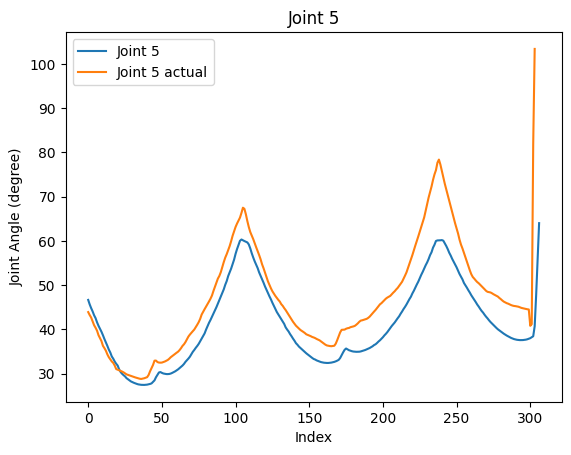

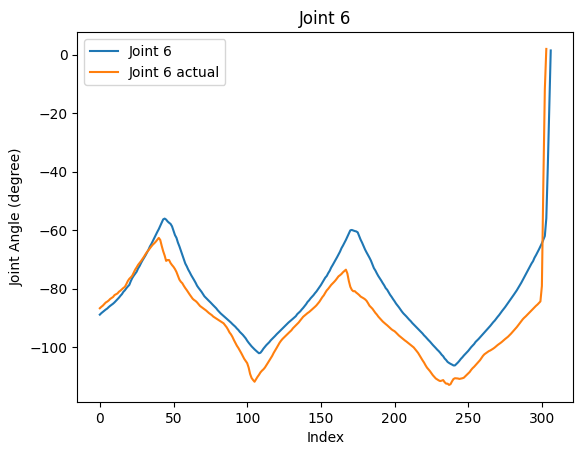

In [3]:
neuron = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 150, 200, 250,300]
windowSize = [1, 4]

for windowSizei in windowSize:
  #==== Generate time series dataset ====
  windowed_pose_train = []
  windowed_jointsAngle_train = []

  windowed_pose_test = []
  windowed_jointsAngle_test = []

  for i in range(len(pose_train) - windowSizei + 1):
      windowed_pose_train.append(pose_train[i : i + windowSizei])
      windowed_jointsAngle_train.append(jointsAngle_train[i + windowSizei - 1])

  for i in range(len(pose_test) - windowSizei + 1):
      windowed_pose_test.append(pose_test[i : i + windowSizei])
      windowed_jointsAngle_test.append(jointsAngle_test[i + windowSizei - 1])

  windowed_pose_train = np.array(windowed_pose_train)
  windowed_jointsAngle_train = np.array(windowed_jointsAngle_train)

  windowed_pose_test = np.array(windowed_pose_test)
  windowed_jointsAngle_test = np.array(windowed_jointsAngle_test)

  for neuroni in neuron:
    #Folder for saving the data
    folder_path = '/content/drive/MyDrive/PercobaanTA/RNN'+'_'+str(windowSizei)+'_1_'+str(neuroni)
    if os.path.exists(folder_path):
          continue
    os.makedirs(folder_path, exist_ok=True)



    #==== LSTM Model ====
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.SimpleRNN(neuroni, activation='relu',  input_shape=(windowSizei, 6)))
    #model.add(LSTM(neuroni, activation='relu', return_sequences=True))
    #model.add(LSTM(neuroni, activation='relu'))
    #model.add(Flatten())
    model.add(Dense(6))

    model.compile(optimizer='adam', loss='mse')

    #==== Target Function ====
    class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss') <= 50): # Experiment with changing this value
          print("\nReached loss less than 0.2 so cancelling training!")
          self.model.stop_training = True

    #==== Train Model ====
    callbacks = myCallback()


    #history = model.fit(pose_train, jointsAngle_train, epochs=3000, batch_size=32, callbacks=[callbacks])

    history = model.fit(windowed_pose_train, windowed_jointsAngle_train, epochs=3000, batch_size=32, validation_data=(windowed_pose_test, windowed_jointsAngle_test), callbacks=[callbacks])

    # Plot loss data
    loss_data = history.history['loss']
    loss_data_plotted = loss_data[1:]

    val_loss_data = history.history['val_loss']
    val_loss_data_plotted = val_loss_data[1:]

    plt.figure()
    plt.plot(range(len(loss_data_plotted)), loss_data_plotted, label='Loss')
    plt.plot(range(len(val_loss_data_plotted)), val_loss_data_plotted, label='Evaluation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss value')
    plt.title('Loss')
    plt.legend()
    # Save loss plot
    plt.savefig(os.path.join(folder_path, 'loss.png'))
    plt.show()

    print(val_loss_data[-1])
    print(loss_data[-1])

    # Write loss and eval loss value
    loss_file = folder_path + '/loss.txt'

    # Open the file in write mode
    with open(loss_file, 'w') as file:
        # Write content to the file
        file.write('Loss = '+str(loss_data[-1])+'\n')
        file.write('Eval loss = '+str(val_loss_data[-1])+'\n')
        file.write('Epoch = '+str(len(loss_data))+'\n')

    #==== Prediction Test ====
    pose_predict = model.predict(windowed_pose_test)

    print(pose_predict)

    # Save prediction data into csv file
    header = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4', 'Joint 5', 'Joint 6']
    rows = pose_predict.tolist()  # Convert predictions to a list
    csv_file = folder_path + '/Predictions_KUKA.csv'

    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)
        writer.writerows(rows)

    i = 0
    jointsAngle_test = jointsAngle[split_index:]
    joint = 1
    # Plot joint angle test data and joint angle prediction
    for column in jointsAngle_test:
        input_data = jointsAngle_test[column]
        predict_data = pose_predict[:, i]
        i = i+1
        plt.figure()
        plt.plot(range(len(input_data)), input_data, label=column)
        plt.plot(range(len(predict_data)), predict_data, label = column + ' actual')
        plt.xlabel('Index')
        plt.ylabel('Joint Angle (degree)')
        plt.title(column)
        plt.legend()
        # Save plot to folder
        plt.savefig(os.path.join(folder_path, 'A'+str(joint)+'.png'))
        joint = joint+1
        plt.show()



Octagon Dataset

In [8]:
#==== Import Dataset ====
dataset = pd.read_csv('/content/drive/MyDrive/PercobaanTA/Octagon_dataset_bersih.csv')

pose = dataset.iloc[:, 6:].values   # Input labels (last six columns)
jointsAngle = dataset.iloc[:, :6].values   # Output features (first six columns)

pose_columns = ['Position x', 'Position y', 'Position z', 'Roll', 'Pitch', 'Yaw']  # Replace with your actual column names
jointsAngle_columns = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4', 'Joint 5', 'Joint 6']  # Replace with your actual column names



test

halo
1/1 [==============================] - 0s 24ms/step
[[ -25.948997  -124.40914    145.32275     32.698395    34.112633
   -47.614105 ]
 [  -7.313352  -133.80367    147.5335       9.768034    34.332874
   -14.742712 ]
 [  10.426697  -131.36832    145.67618    -15.1896105   31.61325
    21.570375 ]
 [  11.191763  -110.337685   138.11002    -24.486525    23.378998
    33.25499  ]
 [   3.1269472  -95.14736    125.17946    -15.469887    16.927868
    17.986063 ]
 [  -8.592953   -91.14373    120.849396     9.517449    14.310121
   -15.782409 ]]
Mean Squared Error: 10.464926719665527


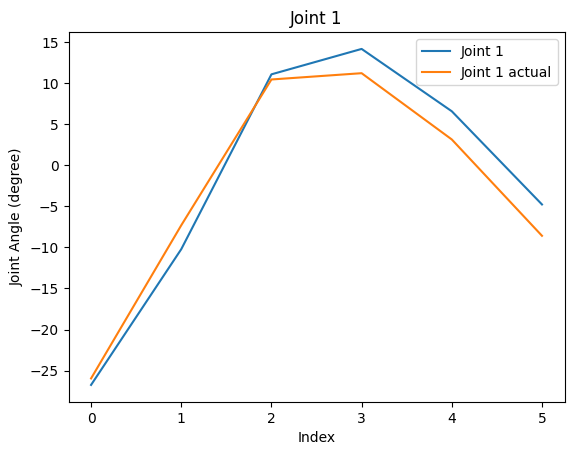

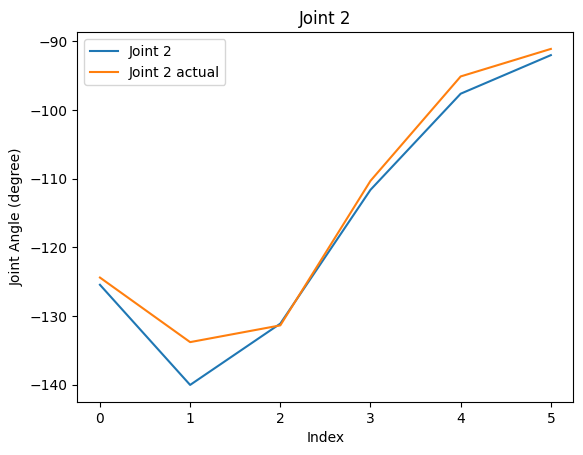

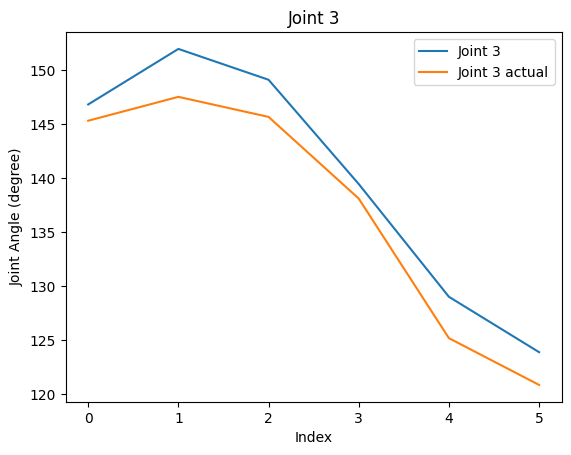

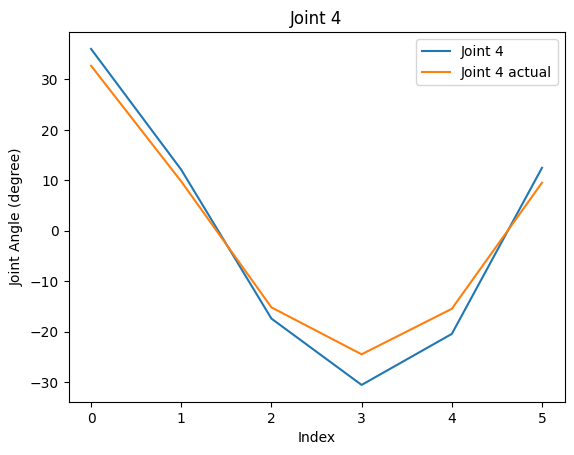

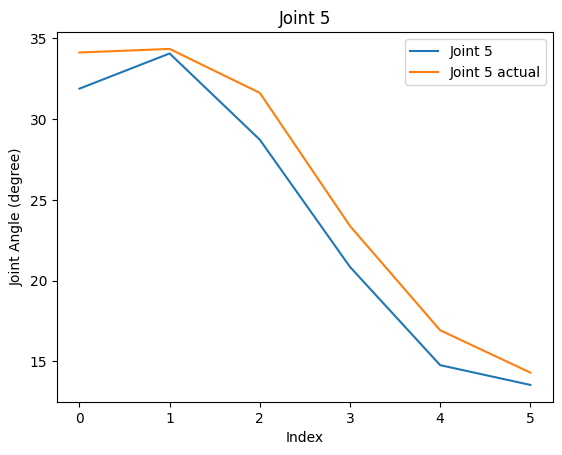

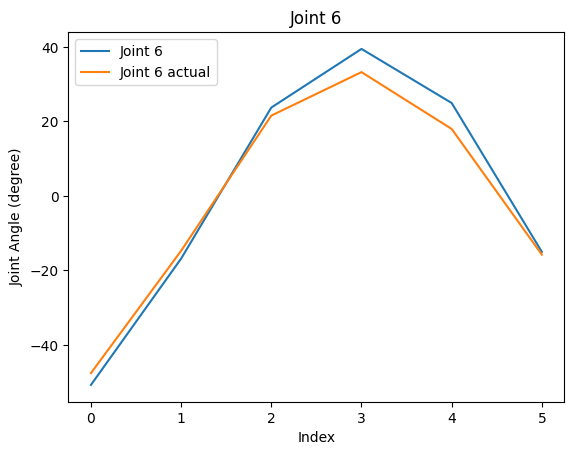

In [11]:
neuron = [200]
windowSize = [4]
for windowSizei in windowSize:
  #==== Generate time series dataset ====
  windowed_pose_test = []
  windowed_jointsAngle_test = []



  for i in range(len(pose) - windowSizei + 1):
      windowed_pose_test.append(pose[i : i + windowSizei])
      windowed_jointsAngle_test.append(jointsAngle[i + windowSizei - 1])

  windowed_pose_test = np.array(windowed_pose_test)
  windowed_jointsAngle_test = np.array(windowed_jointsAngle_test)

  for neuroni in neuron:
    #Folder for saving the data
    folder_path = '/content/drive/MyDrive/PercobaanTA/RNN'+'_'+str(windowSizei)+'_1_'+str(neuroni)+'/octagon'

    os.makedirs(folder_path, exist_ok=True)

    print('halo')
    #==== Prediction Test ====
    pose_predict = model.predict(windowed_pose_test)

    print(pose_predict)

    # Calculate error
    mse = tf.keras.losses.MeanSquaredError()(windowed_jointsAngle_test, pose_predict).numpy()
    print(f"Mean Squared Error: {mse}")

    # Write loss and eval loss value
    error_file = folder_path + '/error.txt'

    # Open the file in write mode
    with open(error_file, 'w') as file:
        # Write content to the file
        file.write(f"Mean Squared Error: {mse}")


    # Save prediction data into csv file
    header = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4', 'Joint 5', 'Joint 6']
    rows = pose_predict.tolist()  # Convert predictions to a list
    csv_file = folder_path + '/Predictions_octagon_KUKA.csv'

    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)
        writer.writerows(rows)

    i = 0
    jointsAngle_test = dataset.iloc[3:9, :6]
    joint = 1

    # Plot joint angle test data and joint angle prediction
    for column in jointsAngle_test:
        input_data = jointsAngle_test[column]
        predict_data = pose_predict[:, i]
        i = i+1
        plt.figure()
        plt.plot(range(len(input_data)), input_data, label=column)
        plt.plot(range(len(predict_data)), predict_data, label = column + ' actual')
        plt.xlabel('Index')
        plt.ylabel('Joint Angle (degree)')
        plt.title(column)
        plt.legend()

        # Save plot to folder
        plt.savefig(os.path.join(folder_path, 'A'+str(joint)+'.png'))
        joint = joint+1
        plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')